In [0]:
"""
Author: Aaditya R Jadhav
"""

import numpy as np
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import cv2, os, glob
from PIL import Image
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense,BatchNormalization,MaxPool2D,Dropout,Flatten,Input,LeakyReLU,GlobalMaxPool2D
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.applications import VGG16,Xception,InceptionResNetV2,NASNetLarge
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

Using TensorFlow backend.


In [0]:
train_data = pd.read_csv(r"/content/train.csv")
target = train_data.Class#.cat.codes
train_img_lst = train_data.Image.to_list()
train_data.Class.value_counts()

test_df = pd.read_csv(r"/content/test.csv")
test_img_lst = test_df.Image.to_list()


In [0]:
def zip_to_data(zipname):
  img_zip = ZipFile("/content/"+str(zipname)+".zip",'r')
  data = []
  try:
    for f1 in train_img_lst:
      img = img_zip.extract(str(zipname)+"/"+f1)
      img = cv2.imread(img)[...,::-1]
      img = Image.fromarray(img)
      img = img.resize((150,150),Image.BILINEAR)
      img = np.array(img)
      data.append(img)
  except:
    for f1 in test_img_lst:
      img = img_zip.extract(str(zipname)+"/"+f1)
      img = cv2.imread(img)[...,::-1]
      img = Image.fromarray(img)
      img = img.resize((150,150),Image.BILINEAR)
      img = np.array(img)
      data.append(img)
      
  data = np.array(data)
  return data
train_data = zip_to_data("Train Images")
print("Train Shape: ",train_data.shape)
test_data = zip_to_data("Test Images")
print("Test Shape: ",test_data.shape)

Train Shape:  (5983, 150, 150, 3)
Test Shape:  (3219, 150, 150, 3)


(<matplotlib.image.AxesImage at 0x7f45f8ba0048>,
 <matplotlib.image.AxesImage at 0x7f45f8ba0320>)

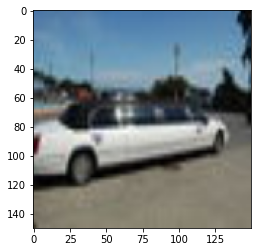

In [0]:
train_data.shape
plt.imshow(train_data[-1]),plt.imshow(test_data[-1])

In [0]:
NUM_CLASSES =4
train_x,test_x,train_y,test_y = train_test_split(train_data, target, test_size=0.001, stratify = target,random_state = 42)
train_x = np.array(train_data)
train_y = np.array(target)
print(train_x.shape)
print(target.shape)
train_x = train_x.astype('float32')/255.0
test_x = test_x.astype('float32')/255.0

Label_encdr = LabelEncoder()
train_y = Label_encdr.fit_transform(train_y)
test_y = Label_encdr.transform(test_y)
train_y = to_categorical(train_y, num_classes=NUM_CLASSES)
test_y = to_categorical(test_y, num_classes=NUM_CLASSES)

(5983, 150, 150, 3)
(5983,)


In [0]:
train_x.shape,train_y.shape

((5983, 150, 150, 3), (5983, 4))

In [0]:
datagen_train = ImageDataGenerator(	#rescale=1./255.0,
                                    rotation_range=10,
                                    zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    fill_mode="nearest"
                                   )
# balanced_gen = BalancedDataGenerator(train_x, train_y, datagen_train, batch_size=128)
# steps_per_epoch = balanced_gen.steps_per_epoch
datagen_train.fit(train_x)

In [0]:
input_layer = Input((150,150,3))

xcep = Xception(weights = 'imagenet',include_top = False,pooling = 'avg')
for layers in xcep.layers[:60]:
  layers.trainable = False

# IncepRes = InceptionResNetV2(input_tensor = input_layer,weights = 'imagenet',include_top = False)
# for layers in IncepRes.layers[:400]:
#   layers.trainable = False
# x = IncepRes.output

# VG16 = VGG16(input_shape = (150,150,3),include_top = False)
# for layers in VG16.layers[:5]:
#   layers.trainable = False
# x = VG16.output

# resnet = ResNet50(weights = "imagenet",include_top = False)
# for layers in resnet.layers[:10]:
#   layers.trainable = False

# nasnet = NASNetLarge(input_tensor = input_layer,weights='imagenet',include_top = False)

x = xcep(input_layer)
#x = GlobalMaxPool2D()(x)

# x = Dense(1024)(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Dropout(0.5)(x)


x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)


# x = Dense(256)(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Dropout(0.5)(x)



output_layer = Dense(4,activation = 'softmax')(x)

model = Model(input_layer,output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
opt = Adam()#lr=0.005)
model.compile(loss = 'categorical_crossentropy',optimizer='adam', metrics = ['acc',f1_m])

checkpointer = ModelCheckpoint("best_model.h5",save_best_only=True, verbose=1,monitor='f1_m',mode = 'max',)
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
#Amodel.compile(loss = 'categorical_crossentropy',optimizer=opt, metrics = ['acc',f1_m])

In [0]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
batch_size = 128
history = model.fit_generator(datagen_train.flow(train_x, train_y, batch_size=batch_size),
                              #validation_data=(test_x,test_y),
                              steps_per_epoch = 120,#np.ceil(train_x.shape[0]/batch_size),
                              epochs = 100,
                              callbacks = [checkpointer,reduce_learning_rate],
                              #max_queue_size=100,
                              workers = 8 ,# (set a proper value > 1)
                              use_multiprocessing=True,
                              )


In [0]:
# Save Model
model.save('model_'+str(round(score_list[2],5))+".h5")

In [0]:
# Predict for test cases
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(test_data)
predictions = best_model.predict_generator(test_datagen.flow(test_data,batch_size = 1,shuffle = False),steps = len(test_data))
pred = np.argmax(predictions,axis = 1)
pred = Label_encdr.inverse_transform(pred)
print(pred)

['Decorationandsignage' 'Food' 'misc' ... 'misc' 'misc' 'misc']


In [0]:
# Create Solution DataFrame
pred_df = pd.DataFrame({"Image":test_df.Image,"Class":pred})
pred_all_df = pd.DataFrame(predictions,columns=Label_encdr.classes_)

In [0]:
# Write to csv
pred_df.to_csv(r'/content/solution.csv',index = False)
pred_all_df.to_csv(r'/content/pred_all.csv',index = False)